The landsat_hires netcdf file can be found at http://glasslab.engr.ccny.cuny.edu/u/hannah/eas213/landsat_hires.nc
The NYC census tracts can be found at https://github.com/story645/EAS213/tree/master/data

If you have the file on your computer, set the path to the location on disk:

```python
datapath = "/path/to/landsat_hires.nc"
shapepath = "/path/to/census.geojson"
```
if you are running the file via mybinder (the interactive version), then set the path to the managed version of the data:

```python
from quilt.data.story645 import eas213
datapath = eas213.landsat_hires._data()
geopath = eas213.census._data()
```

You can also install quilt and the data package on your computer to access the data. To do so, enter the following commands in a terminal or anaconda command prompt:

```bash
pip install quilt
quilt install story645/eas213
```


In [ ]:
# set the data and geo paths
datapath =
geopath = 

In [1]:
from quilt.data.story645 import eas213
datapath = eas213.landsat_hires._data()
geopath = eas213.census._data()

In [2]:
import geopandas as gpd
tracts = gpd.read_file(geopath, crs={'epsg':2263})

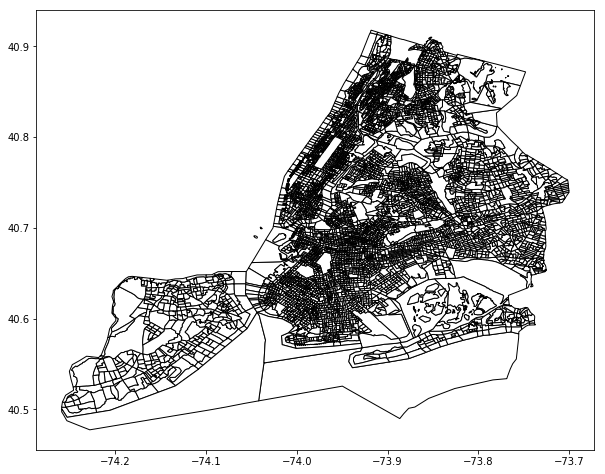

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))

_ = tracts.plot(ax=ax, edgecolor='k', color='w')

In [4]:
import xarray as xr
ds = xr.open_dataset('../data/landsat_hires.nc')

In [5]:
import landsat_sample_functions as lf
# pull out the thermal radiances from from ds and convert them to temperature
tempK = lf.BT(ds['Thermal Radiances'], 10.9, 1)
#convert the temperature to Fahrenheit
tempF = 9/5*(tempK - 273) + 32

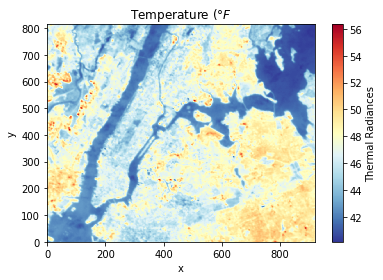

In [9]:
fig, ax = plt.subplots()
_ = tempF.mean('time').plot(cmap='RdYlBu_r', ax=ax)
_ = ax.set_title(r"Temperature ($\degree F$")

# How do we combine the two?

In [44]:
# let's stay w/ the mean to reduce the size of the data
temps = tempF.mean('time').to_dataframe().reset_index()

In [45]:
temps.head()

,y,x,Thermal Radiances
0,0,0,46.148373
1,0,1,45.559336
2,0,2,45.114883
3,0,3,44.802350
4,0,4,44.601317


In [65]:
ds.lat.shape

(21, 815, 921)

In [67]:
ds.dims

Frozen(SortedKeysDict({u'y': 815, u'x': 921, u'time': 21}))

In [72]:
temps['y'].max()

814

In [63]:
#lets get back the lats and lons by indexing into dataset coordinates
lats = ds.lat.mean('time')[temps['y'].tolist()]
lons = ds.lon.mean('time')[temps['x'].tolist()]

IndexError: index 815 is out of bounds for axis 0 with size 815

In [17]:
#convert to a geodataframe 
from shapely.geometry import Point
temps['Coordinates']  = list(zip(lats, lons))
temps['Coordinates'] = temps['Coordinates'].apply(Point)

In [28]:
tempgdf = gpd.GeoDataFrame(temps, geometry='Coordinates', crs={'epsg':2263})

In [29]:
tempgdf.head()

,y,x,Thermal Radiances,Coordinates
0,0,0,46.148373,POINT (0 0)
1,0,1,45.559336,POINT (1 0)
2,0,2,45.114883,POINT (2 0)
3,0,3,44.802350,POINT (3 0)
4,0,4,44.601317,POINT (4 0)


In [30]:
tracts.head()

,OBJECTID,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geo_id,OBJECTID_1,GEOID_1,SHAPE_Leng,SHAPE_Area,geometry
0,2038,36,081,014000,1,360810140001,Block Group 1,G5030,S,113131.0,0.0,+40.7030341,-073.8279064,15000US360810140001,10466,15000US360810140001,0.020864,0.000012,"POLYGON ((-73.82266 40.703585, -73.8233 40.703..."
1,2039,36,081,014100,1,360810141001,Block Group 1,G5030,S,22906.0,0.0,+40.7681196,-073.9103709,15000US360810141001,10468,15000US360810141001,0.006593,0.000002,"POLYGON ((-73.91088999999999 40.76758, -73.911..."
2,2040,36,081,014201,2,360810142012,Block Group 2,G5030,S,115513.0,0.0,+40.7000618,-073.8243325,15000US360810142012,10471,15000US360810142012,0.015220,0.000012,"POLYGON ((-73.82125000000001 40.699699, -73.82..."
3,2041,36,081,014201,1,360810142011,Block Group 1,G5030,S,92948.0,0.0,+40.7021186,-073.8249086,15000US360810142011,10470,15000US360810142011,0.014664,0.000010,"POLYGON ((-73.8233 40.703353, -73.82266 40.703..."
4,2042,36,081,014202,1,360810142021,Block Group 1,G5030,S,200156.0,0.0,+40.7009838,-073.8181909,15000US360810142021,10472,15000US360810142021,0.022728,0.000021,"POLYGON ((-73.82246000000001 40.703656, -73.82..."


In [35]:
# join the arrays such that all temps in a tract are assigned to that tract
tt = gpd.sjoin(tracts, tempgdf, how="inner", op='contains')

In [39]:
tempgdf

,y,x,Thermal Radiances,Coordinates
0,0,0,46.148373,POINT (0 0)
1,0,1,45.559336,POINT (1 0)
2,0,2,45.114883,POINT (2 0)
3,0,3,44.802350,POINT (3 0)
4,0,4,44.601317,POINT (4 0)
5,0,5,44.446757,POINT (5 0)
6,0,6,44.255093,POINT (6 0)
7,0,7,44.044396,POINT (7 0)
8,0,8,43.834786,POINT (8 0)
9,0,9,43.652314,POINT (9 0)


In [ ]:
#look up your tract
# https://popfactfinder.planning.nyc.gov/profile/7547/census